# Vibe Matcher - Fashion Recommendation System

**Nexora Internship Assignment**

Mini recommendation system using OpenRouter API:
1. Input vibe query
2. Embed products using OpenRouter (OpenRouter text-embedding-3-small embeddings)
3. Match top-3 via cosine similarity
------
(Scroll Down For Introduction)

## Setup & Dependencies

In [11]:
import pandas as pd
import numpy as np
import requests
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Data Preparation - Mock Fashion Products

In [12]:
products_data = [
    {"id": 1, "name": "Boho Maxi Dress", "description": "Flowy, earthy tones maxi dress perfect for festival vibes. Features intricate embroidery and relaxed silhouette.", "vibes": ["boho", "festival", "relaxed"], "price": 89.99},
    {"id": 2, "name": "Urban Leather Jacket", "description": "Edgy black leather jacket with silver zippers. Perfect for energetic urban chic style.", "vibes": ["urban", "edgy", "chic"], "price": 249.99},
    {"id": 3, "name": "Cozy Knit Sweater", "description": "Oversized chunky knit sweater in warm cream. Soft, comfortable for cozy winter days.", "vibes": ["cozy", "comfort", "winter"], "price": 65.00},
    {"id": 4, "name": "Minimalist Blazer", "description": "Clean-cut tailored blazer in neutral beige. Sophisticated professional minimalist aesthetic.", "vibes": ["minimalist", "professional"], "price": 179.99},
    {"id": 5, "name": "Vintage Denim Jacket", "description": "Classic distressed denim with retro patches. Casual vintage style for laid-back weekends.", "vibes": ["vintage", "casual", "retro"], "price": 95.00},
    {"id": 6, "name": "Athletic Joggers", "description": "High-performance moisture-wicking joggers. Designed for active energetic sporty lifestyle.", "vibes": ["athletic", "sporty", "energetic"], "price": 55.00},
    {"id": 7, "name": "Romantic Silk Blouse", "description": "Delicate silk blouse in soft blush pink with ruffles. Feminine elegant for romantic dates.", "vibes": ["romantic", "feminine", "elegant"], "price": 125.00},
    {"id": 8, "name": "Streetwear Hoodie", "description": "Bold graphic hoodie with urban street art. Energetic trendy for contemporary city lifestyle.", "vibes": ["streetwear", "urban", "trendy"], "price": 75.00},
    {"id": 9, "name": "Bohemian Kimono", "description": "Flowing kimono with exotic floral patterns. Free-spirited boho for festival season.", "vibes": ["boho", "free-spirited", "festival"], "price": 68.00},
    {"id": 10, "name": "Smart Casual Chinos", "description": "Versatile slim-fit chinos in navy. Modern professional style for office to evening.", "vibes": ["smart-casual", "versatile", "professional"], "price": 79.99}
]

df_products = pd.DataFrame(products_data)
print(f"Created dataset with {len(df_products)} fashion products\n")
df_products

Created dataset with 10 fashion products



,id,name,description,vibes,price
0,1,Boho Maxi Dress,"Flowy, earthy tones maxi dress perfect for fes...","[boho, festival, relaxed]",89.99
1,2,Urban Leather Jacket,Edgy black leather jacket with silver zippers....,"[urban, edgy, chic]",249.99
2,3,Cozy Knit Sweater,Oversized chunky knit sweater in warm cream. S...,"[cozy, comfort, winter]",65.00
3,4,Minimalist Blazer,Clean-cut tailored blazer in neutral beige. So...,"[minimalist, professional]",179.99
4,5,Vintage Denim Jacket,Classic distressed denim with retro patches. C...,"[vintage, casual, retro]",95.00
5,6,Athletic Joggers,High-performance moisture-wicking joggers. Des...,"[athletic, sporty, energetic]",55.00
6,7,Romantic Silk Blouse,Delicate silk blouse in soft blush pink with r...,"[romantic, feminine, elegant]",125.00
7,8,Streetwear Hoodie,Bold graphic hoodie with urban street art. Ene...,"[streetwear, urban, trendy]",75.00
8,9,Bohemian Kimono,Flowing kimono with exotic floral patterns. Fr...,"[boho, free-spirited, festival]",68.00
9,10,Smart Casual Chinos,Versatile slim-fit chinos in navy. Modern prof...,"[smart-casual, versatile, professional]",79.99


## 2. OpenRouter API Setup

In [13]:
OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY')

if OPENROUTER_API_KEY:
    print("OpenRouter API key loaded")
else:
    print("Error")

OpenRouter API key loaded


## 3. Embedding Functions

In [14]:
def get_embedding(text: str, model: str = "openai/text-embedding-3-small") -> List[float]:
    try:
        text = text.replace("\n", " ")
        response = requests.post(
            url="https://openrouter.ai/api/v1/embeddings",
            headers={
                "Authorization": f"Bearer {OPENROUTER_API_KEY}",
                "Content-Type": "application/json"
            },
            json={
                "model": model,
                "input": text
            }
        )
        response.raise_for_status()
        return response.json()['data'][0]['embedding']
    except Exception as e:
        print(f"Error: {e}")
        return None

def get_embeddings_batch(texts: List[str], model: str = "openai/text-embedding-3-small") -> List[List[float]]:
    try:
        texts = [text.replace("\n", " ") for text in texts]
        response = requests.post(
            url="https://openrouter.ai/api/v1/embeddings",
            headers={
                "Authorization": f"Bearer {OPENROUTER_API_KEY}",
                "Content-Type": "application/json"
            },
            json={
                "model": model,
                "input": texts
            }
        )
        response.raise_for_status()
        data = response.json()['data']
        return [item['embedding'] for item in sorted(data, key=lambda x: x['index'])]
    except Exception as e:
        print(f"Error: {e}")
        return None

print("Embedding functions defined")
print("Using OpenRouter with text-embedding-3-small")

Embedding functions defined
Using OpenRouter with text-embedding-3-small


## 4. Generate Product Embeddings

In [15]:
print("Generating embeddings for products...\n")
start = time.time()

df_products['combined_text'] = df_products.apply(
    lambda r: f"{r['name']}. {r['description']} Vibes: {', '.join(r['vibes'])}",
    axis=1
)

embeddings = get_embeddings_batch(df_products['combined_text'].tolist())

if embeddings:
    df_products['embedding'] = embeddings
    elapsed = time.time() - start
    print(f"Generated {len(df_products)} embeddings")
    print(f"Embedding dimension: {len(embeddings[0])}")
    print(f"Time: {elapsed:.2f}s ({elapsed/len(df_products):.2f}s per product)")
else:
    print("Failed to generate embeddings. Check your API key.")

Generating embeddings for products...

Generated 10 embeddings
Embedding dimension: 1536
Time: 2.79s (0.28s per product)


## 5. Cosine Similarity Search Functions

In [16]:
def find_similar_products(query: str, df: pd.DataFrame, top_k: int = 3, threshold: float = 0.0) -> Tuple[pd.DataFrame, float]:
    start = time.time()
    
    
    query_embedding = get_embedding(query)
    
    if query_embedding is None:
        print("Failed to generate query embedding")
        return pd.DataFrame(), 0.0
    
    query_vec = np.array(query_embedding).reshape(1, -1)
    product_vecs = np.array(df['embedding'].tolist())
    
    similarities = cosine_similarity(query_vec, product_vecs)[0]
    
    df_results = df.copy()
    df_results['similarity_score'] = similarities
    df_results = df_results[df_results['similarity_score'] >= threshold]
    df_results = df_results.sort_values('similarity_score', ascending=False)
    
    return df_results.head(top_k), time.time() - start

def display_results(query: str, results: pd.DataFrame, latency: float):
    """
    Display search results in formatted output.
    """
    print(f"\n{'='*80}")
    print(f"QUERY: '{query}'")
    print(f"{'='*80}\n")
    
    if len(results) == 0:
        print("No matches found. Try lowering the threshold.\n")
        return
    
    for idx, row in results.iterrows():
        rank = results.index.get_loc(idx) + 1
        print(f"🏆 Rank #{rank}: {row['name']}")
        print(f"   {row['description']}")
        print(f"   Vibes: {', '.join(row['vibes'])} | ${row['price']:.2f}")
        print(f"   ⭐ Similarity Score: {row['similarity_score']:.4f}", end="")
        
        if row['similarity_score'] >= 0.7:
            print(" - EXCELLENT MATCH")
        elif row['similarity_score'] >= 0.5:
            print(" - GOOD MATCH")
        else:
            print(" - MODERATE MATCH")
        print()
    
    print(f"⏱️  Query Latency: {latency:.3f}s")
    print(f"{'='*80}\n")

print("Search functions ready")

Search functions ready


## 6. Testing - Query 1: Energetic Urban Chic

In [17]:
query1 = "energetic urban chic"
results1, latency1 = find_similar_products(query1, df_products, top_k=3)
display_results(query1, results1, latency1)


QUERY: 'energetic urban chic'

🏆 Rank #1: Urban Leather Jacket
   Edgy black leather jacket with silver zippers. Perfect for energetic urban chic style.
   Vibes: urban, edgy, chic | $249.99
   ⭐ Similarity Score: 0.5895 - GOOD MATCH

🏆 Rank #2: Streetwear Hoodie
   Bold graphic hoodie with urban street art. Energetic trendy for contemporary city lifestyle.
   Vibes: streetwear, urban, trendy | $75.00
   ⭐ Similarity Score: 0.5427 - GOOD MATCH

🏆 Rank #3: Athletic Joggers
   High-performance moisture-wicking joggers. Designed for active energetic sporty lifestyle.
   Vibes: athletic, sporty, energetic | $55.00
   ⭐ Similarity Score: 0.4284 - MODERATE MATCH

⏱️  Query Latency: 2.788s



## 7. Testing - Query 2: Cozy Comfortable Winter

In [18]:
query2 = "cozy comfortable winter style"
results2, latency2 = find_similar_products(query2, df_products, top_k=3)
display_results(query2, results2, latency2)


QUERY: 'cozy comfortable winter style'

🏆 Rank #1: Cozy Knit Sweater
   Oversized chunky knit sweater in warm cream. Soft, comfortable for cozy winter days.
   Vibes: cozy, comfort, winter | $65.00
   ⭐ Similarity Score: 0.6356 - GOOD MATCH

🏆 Rank #2: Streetwear Hoodie
   Bold graphic hoodie with urban street art. Energetic trendy for contemporary city lifestyle.
   Vibes: streetwear, urban, trendy | $75.00
   ⭐ Similarity Score: 0.3823 - MODERATE MATCH

🏆 Rank #3: Vintage Denim Jacket
   Classic distressed denim with retro patches. Casual vintage style for laid-back weekends.
   Vibes: vintage, casual, retro | $95.00
   ⭐ Similarity Score: 0.3595 - MODERATE MATCH

⏱️  Query Latency: 1.731s



## 8. Testing - Query 3: Free-Spirited Festival

In [19]:
query3 = "free-spirited festival vibes"
results3, latency3 = find_similar_products(query3, df_products, top_k=3)
display_results(query3, results3, latency3)


QUERY: 'free-spirited festival vibes'

🏆 Rank #1: Bohemian Kimono
   Flowing kimono with exotic floral patterns. Free-spirited boho for festival season.
   Vibes: boho, free-spirited, festival | $68.00
   ⭐ Similarity Score: 0.5491 - GOOD MATCH

🏆 Rank #2: Boho Maxi Dress
   Flowy, earthy tones maxi dress perfect for festival vibes. Features intricate embroidery and relaxed silhouette.
   Vibes: boho, festival, relaxed | $89.99
   ⭐ Similarity Score: 0.5043 - GOOD MATCH

🏆 Rank #3: Streetwear Hoodie
   Bold graphic hoodie with urban street art. Energetic trendy for contemporary city lifestyle.
   Vibes: streetwear, urban, trendy | $75.00
   ⭐ Similarity Score: 0.3124 - MODERATE MATCH

⏱️  Query Latency: 2.588s



## 9. Performance Metrics & Evaluation

In [20]:
test_results = [
    (query1, results1, latency1),
    (query2, results2, latency2),
    (query3, results3, latency3)
]

metrics = {
    'query': [],
    'num_results': [],
    'avg_similarity': [],
    'max_similarity': [],
    'good_matches': [],  # score >= 0.7
    'latency_ms': []
}

for query, results, latency in test_results:
    metrics['query'].append(query)
    metrics['num_results'].append(len(results))
    metrics['avg_similarity'].append(results['similarity_score'].mean() if len(results) > 0 else 0)
    metrics['max_similarity'].append(results['similarity_score'].max() if len(results) > 0 else 0)
    metrics['good_matches'].append(len(results[results['similarity_score'] >= 0.7]) if len(results) > 0 else 0)
    metrics['latency_ms'].append(latency * 1000)

df_metrics = pd.DataFrame(metrics)

print("\n📊 EVALUATION METRICS\n")
print(df_metrics.to_string(index=False))

print(f"\n\n📈 SUMMARY STATISTICS")
print(f"Average Latency: {df_metrics['latency_ms'].mean():.2f} ms")
print(f"Average Similarity Score: {df_metrics['avg_similarity'].mean():.4f}")
total_good = df_metrics['good_matches'].sum()
total_results = df_metrics['num_results'].sum()
if total_results > 0:
    print(f"Total Good Matches (≥0.7): {total_good}/{total_results} ({total_good/total_results*100:.1f}%)")
else:
    print(f"Total Good Matches (≥0.7): 0/0")


📊 EVALUATION METRICS

                        query  num_results  avg_similarity  max_similarity  good_matches  latency_ms
         energetic urban chic            3        0.520218        0.589532             0 2787.885427
cozy comfortable winter style            3        0.459154        0.635643             0 1731.440306
 free-spirited festival vibes            3        0.455245        0.549068             0 2587.997437


📈 SUMMARY STATISTICS
Average Latency: 2369.11 ms
Average Similarity Score: 0.4782
Total Good Matches (≥0.7): 0/9 (0.0%)


## 10. Visualizations

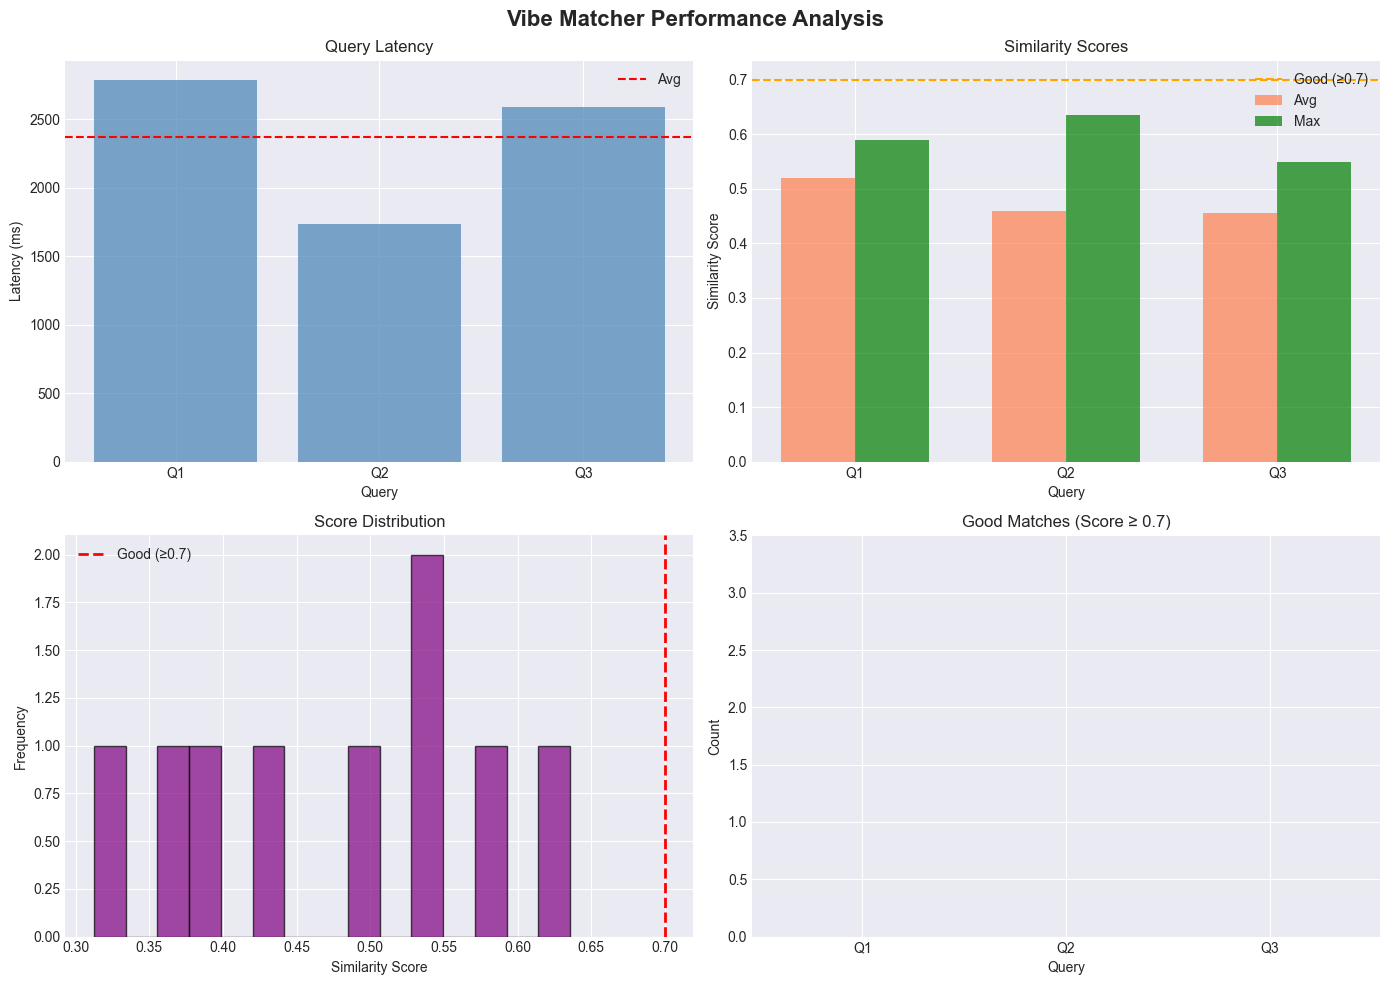

Visualizations generated


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Vibe Matcher Performance Analysis', fontsize=16, fontweight='bold')


axes[0, 0].bar(range(3), df_metrics['latency_ms'], color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Query')
axes[0, 0].set_ylabel('Latency (ms)')
axes[0, 0].set_title('Query Latency')
axes[0, 0].set_xticks(range(3))
axes[0, 0].set_xticklabels(['Q1', 'Q2', 'Q3'])
axes[0, 0].axhline(y=df_metrics['latency_ms'].mean(), color='r', linestyle='--', label='Avg')
axes[0, 0].legend()


x = np.arange(3)
width = 0.35
axes[0, 1].bar(x - width/2, df_metrics['avg_similarity'], width, label='Avg', color='coral', alpha=0.7)
axes[0, 1].bar(x + width/2, df_metrics['max_similarity'], width, label='Max', color='green', alpha=0.7)
axes[0, 1].set_xlabel('Query')
axes[0, 1].set_ylabel('Similarity Score')
axes[0, 1].set_title('Similarity Scores')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['Q1', 'Q2', 'Q3'])
axes[0, 1].axhline(y=0.7, color='orange', linestyle='--', label='Good (≥0.7)')
axes[0, 1].legend()

all_scores = []
for _, results, _ in test_results:
    if len(results) > 0:
        all_scores.extend(results['similarity_score'].tolist())

if all_scores:
    axes[1, 0].hist(all_scores, bins=15, color='purple', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='Good (≥0.7)')
    axes[1, 0].set_xlabel('Similarity Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Score Distribution')
    axes[1, 0].legend()

colors = ['green' if x >= 2 else 'orange' if x >= 1 else 'red' for x in df_metrics['good_matches']]
axes[1, 1].bar(range(3), df_metrics['good_matches'], color=colors, alpha=0.7)
axes[1, 1].set_xlabel('Query')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Good Matches (Score ≥ 0.7)')
axes[1, 1].set_xticks(range(3))
axes[1, 1].set_xticklabels(['Q1', 'Q2', 'Q3'])
axes[1, 1].set_ylim(0, 3.5)

plt.tight_layout()
plt.show()

print("Visualizations generated")

## 11. Edge Case Testing

In [22]:
print("\n🧪 EDGE CASE TESTING\n")

# Edge Case 1: Niche query
print("Test 1: Niche/unusual query")
edge_query1 = "futuristic cyberpunk metallic aesthetic"
edge_results1, edge_latency1 = find_similar_products(edge_query1, df_products, top_k=3, threshold=0.3)
display_results(edge_query1, edge_results1, edge_latency1)


🧪 EDGE CASE TESTING

Test 1: Niche/unusual query

QUERY: 'futuristic cyberpunk metallic aesthetic'

🏆 Rank #1: Urban Leather Jacket
   Edgy black leather jacket with silver zippers. Perfect for energetic urban chic style.
   Vibes: urban, edgy, chic | $249.99
   ⭐ Similarity Score: 0.4045 - MODERATE MATCH

🏆 Rank #2: Streetwear Hoodie
   Bold graphic hoodie with urban street art. Energetic trendy for contemporary city lifestyle.
   Vibes: streetwear, urban, trendy | $75.00
   ⭐ Similarity Score: 0.3602 - MODERATE MATCH

🏆 Rank #3: Minimalist Blazer
   Clean-cut tailored blazer in neutral beige. Sophisticated professional minimalist aesthetic.
   Vibes: minimalist, professional | $179.99
   ⭐ Similarity Score: 0.3330 - MODERATE MATCH

⏱️  Query Latency: 2.517s



In [23]:
# Edge Case 2: High threshold (no matches expected)
print("\nTest 2: Very high threshold (testing fallback)")
edge_query2 = "casual weekend wear"
edge_results2, edge_latency2 = find_similar_products(edge_query2, df_products, top_k=3, threshold=0.95)
display_results(edge_query2, edge_results2, edge_latency2)


Test 2: Very high threshold (testing fallback)

QUERY: 'casual weekend wear'

No matches found. Try lowering the threshold.



## 12. Introduction

I am a final year B.Tech-CSE-AIML student. As an AI and Data Science enthusiast, I've built a strong foundation in machine learning and NLP through my academic projects and internships, where I've developed and deployed practical AI solutions. I'm excited by the opportunity to apply my skills in model building, data analysis, and creating impactful applications to the innovative work at Nexora. I am confident that my hands-on experience and passion for AI will allow me to contribute effectively and learn immensely as an intern on your team.